In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors

/Users/thanasi/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import subprocess

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import palettable as pbl
import h5py

In [328]:
from scipy.optimize import curve_fit

In [66]:
from isanaht import plot_helper as ph

In [4]:
cmap7 = pbl.colorbrewer.get_map('Set1', 'Qualitative', 7)
cmap11 = pbl.colorbrewer.get_map('Paired', 'Qualitative', 12)
c11s = cmap11.hex_colors
c11s = c11s[1::2] + c11s[::2] # unpair them

In [5]:
mpl.rc('image', cmap='coolwarm', interpolation='nearest')
mpl.rc('font', family='STIXGeneral')
mpl.rc('legend', fancybox=False, numpoints=1, markerscale=1.5, borderaxespad=0.5, fontsize=16)
mpl.rc('figure', figsize=(8,8))
mpl.rc('axes', linewidth=1.5, edgecolor='k', labelsize=22, grid=False, axisbelow=True,
        prop_cycle= mpl.cycler(color=c11s))
mpl.rc('grid', linewidth=1)
mpl.rc('ytick.major', size=5, width=1.5, pad=8)
mpl.rc('xtick.major', size=5, width=1.5, pad=8)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('lines', linewidth=2)

---

### Problem 2

In [168]:
def folded(k_):
    k = k_.copy()
    while (k>(np.pi/a)).any():
            k[k>np.pi/a] -= 2*np.pi/a
            k = np.abs(k)
            
    return k

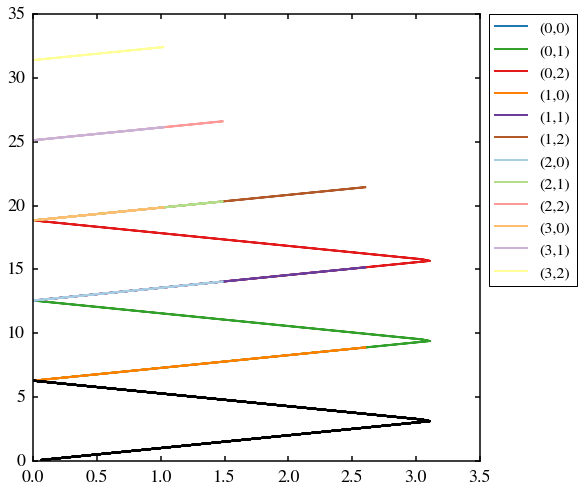

In [174]:
N = 3
M = 2

a = 1
kx = np.linspace(-2*np.pi/a,2*np.pi/a,100)

fig,ax = plt.subplots()

for n in range(N+1):
    for m in range(M+1):
        k = np.sqrt(kx**2 + n**2*(2*np.pi/a)**2) + 2*np.pi*m / a
        omega = np.abs(k)

        ax.plot(folded(k), omega, label="(%d,%d)" %(n,m))
        ax.plot(folded(kx), np.abs(kx), 'k-')
        
ax.legend(**ph.side_legend_settings)


---

### Problem 3a

In [412]:
%%sh
cd 3a
mpb num-bands=1 bandgap1d.ctl | grep tmfreqs > tm.bandgap1d.dat
cd ..

In [411]:
%%sh
cd 3a
mpb deps2=0.0 N=5 defect1d.ctl > defect1d.out
grep tmfreqs: defect1d.out > tm.all.dat
cd ..

In [413]:
N=5

In [414]:
kbands1 = pd.read_csv('./3a/tm.bandgap1d.dat', index_col=[0,1], skipinitialspace=True).loc["tmfreqs:"]
kbands2 = pd.read_csv('./3a/tm.defect1d.dat', index_col=[0,1], skipinitialspace=True).loc["tmfreqs:"]

# k in units of 2π/a
kx1 = kbands1["k1"].values

# for supercell-based calculation, 
# need to divide k by supercell repetition size 
# because k is in units of total cell width = Na
# and in order to compare absolute values of k between the two computations
# need to compensate for this difference
kx2 = kbands2["k1"].values / N 

omega1 = kbands1[["tm band %d" % i for i in range(1,2)]]
omega2 = kbands2[["tm band %d" % i for i in range(1,6)]]

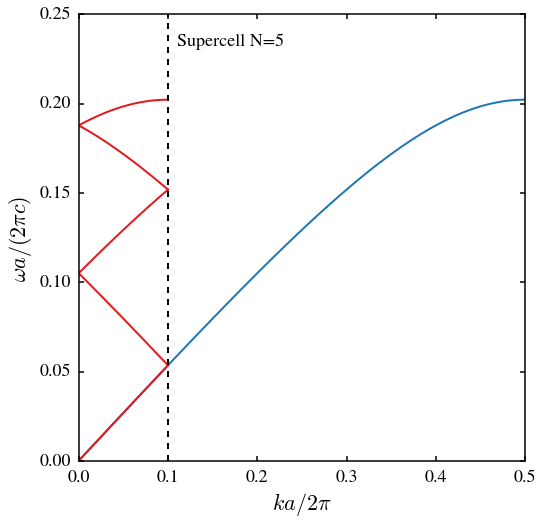

In [415]:
fig,ax = plt.subplots()
ax.plot(kx1, omega1, '-');
ax.plot(kx2, omega2, '-', c=cmap7.mpl_colors[0]);

ax.axvline(0.5/N, ls='--',c='k');

ax.set_ylabel("$\omega a / (2\pi c)$");
ax.set_xlabel("$k a/ 2\pi$");

ax.text(0.5/N + 0.01, 0.24, "Supercell N=5", fontsize=18, horizontalalignment='left', verticalalignment='top');

fig.savefig("3a-1.pdf", bbox_inches='tight', facecolor='none')

---

### Problem 3b

In [56]:
%%sh
cd 3b/eps1
mpb deps1=1.0 deps2=0.0 N=5 defect1d.ctl > defect1d.out
cd ../..

In [58]:
!ls 3b/eps1

defect1d-e.k01.b01.z.tm.h5 defect1d-e.k01.b06.z.tm.h5
defect1d-e.k01.b02.z.tm.h5 defect1d-epsilon.h5
defect1d-e.k01.b03.z.tm.h5 defect1d.ctl
defect1d-e.k01.b04.z.tm.h5 defect1d.out
defect1d-e.k01.b05.z.tm.h5


In [283]:
with h5py.File('./3b/eps1/defect1d-epsilon.h5', 'r') as eps_file:
    epsilon = eps_file["data"].value
    X_max = eps_file["lattice vectors"].value[0,0] / 2
    nX = epsilon.shape[0]
    X = np.mgrid[-X_max:X_max:1j*nX]

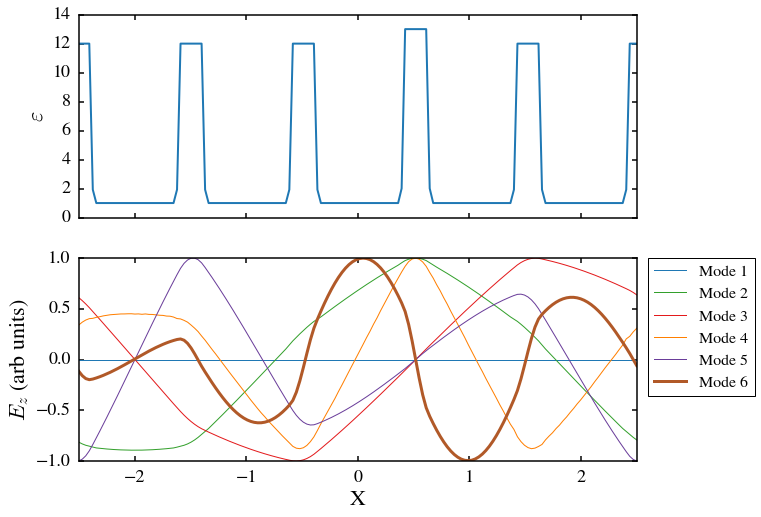

In [286]:
fields_to_plot = [1, 2, 3, 4, 5, 6]

fig,axs = plt.subplots(2,1, figsize=(10,8), sharex='col')
ax0, ax1 = axs

ax0.plot(X,epsilon, '-');

# ax.set_ylim(0,13);
ax0.set_xlim(-X_max, X_max);
ax0.set_ylim(0, epsilon.max() + 1)
ax0.set_ylabel(r"$\varepsilon$");

for i in fields_to_plot:
    with h5py.File("./3b/eps1/defect1d-e.k01.b%02d.z.tm.h5" % i) as field_data:
        efield = field_data["z.r"].value
        X_max = field_data["lattice vectors"].value[0,0] / 2
        nX = efield.shape[0]
        X = np.mgrid[-X_max:X_max:1j*nX]
        
        if (efield==0).all():
            efield_to_plot = efield
        else:
            efield_to_plot = efield / abs(efield).max()
            
        if i<6:
            lw = 1
        else:
            lw=3
        
        ax1.plot(X, efield_to_plot, lw=lw, label="Mode %d" % i)

ax1.set_xlim(-X_max, X_max);
ax1.set_xlabel("X");
ax1.set_ylabel("$E_z$ (arb units)");
ax1.legend(**ph.side_legend_settings);
fig.savefig("3b-1.pdf", bbox_inches='tight', facecolor='none')

In [92]:
%%sh
cd 3b/eps2
mpb deps1=0.0 deps2=1.0 N=5 defect1d.ctl > defect1d.out
cd ../..

In [416]:
with h5py.File('./3b/eps2/defect1d-epsilon.h5', 'r') as eps_file:
    epsilon = eps_file["data"].value
    X_max = eps_file["lattice vectors"].value[0,0] / 2
    nX = epsilon.shape[0]
    X = np.mgrid[-X_max:X_max:1j*nX]

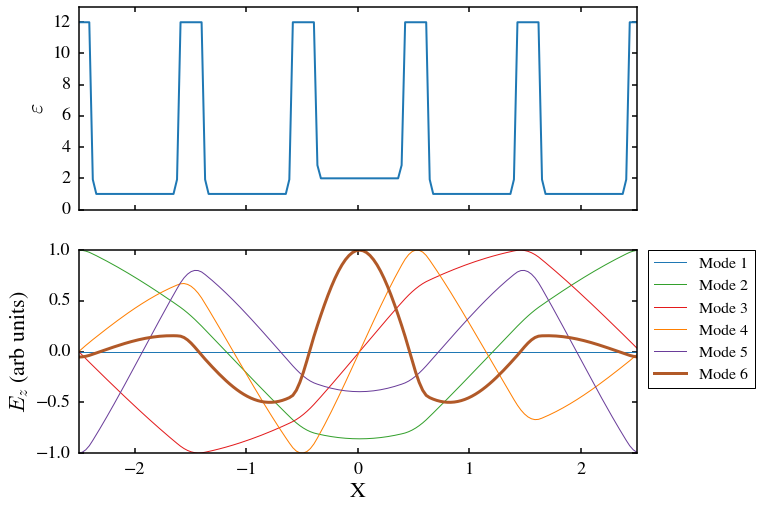

In [417]:
fields_to_plot = [1, 2, 3, 4, 5, 6]

fig,axs = plt.subplots(2,1, figsize=(10,8), sharex='col')
ax0, ax1 = axs

ax0.plot(X,epsilon, '-');

# ax.set_ylim(0,13);
ax0.set_xlim(-X_max, X_max);
ax0.set_ylim(0, epsilon.max() + 1)
ax0.set_ylabel(r"$\varepsilon$");

for i in fields_to_plot:
    with h5py.File("./3b/eps2/defect1d-e.k01.b%02d.z.tm.h5" % i) as field_data:
        efield = field_data["z.r"].value
        X_max = field_data["lattice vectors"].value[0,0] / 2
        nX = efield.shape[0]
        X = np.mgrid[-X_max:X_max:1j*nX]
        
        if (efield==0).all():
            efield_to_plot = efield
        else:
            efield_to_plot = efield / abs(efield).max()
        
        if i<6:
            lw=1
        else:
            lw=3
        
        ax1.plot(X, efield_to_plot, ls='-', lw=lw, label="Mode %d" % i)

ax1.set_xlim(-X_max, X_max);
ax1.set_xlabel("X");
ax1.set_ylabel("$E_z$ (arb units)");
ax1.legend(**ph.side_legend_settings);
fig.savefig("3b-2.pdf", bbox_inches='tight', facecolor='none')

---

### Problem 3c


In [253]:
%%sh
cd 3c
rm *.h5 *.dat
for de in `seq 0 1 30`; do mpb deps2=$de N=40 defect1d.ctl | grep "tmfreqs" > tm.eps2.$de.dat; done && cd ..
cd ..

In [289]:
N = 40
deMAX = 30
deSTEP = 1

deps2 = np.linspace(0.0, deMAX, int(deMAX/deSTEP) + 1)
tm_bands = []

for de in deps2:
    b = pd.read_csv('./3c/tm.eps2.%0.2G.dat' % de, index_col=[0,1], 
                    skipinitialspace=True).loc["tmfreqs:"][["tm band %d" % n for n in range(1,N+6)]].values
    tm_bands.append(b)

In [290]:
tm_bands = np.array(tm_bands)[:,0,:]

In [291]:
tm_bands /= N

In [292]:
bands = pd.DataFrame(data=tm_bands, index=deps2, columns=[["tm band %d" % n for n in range(1,N+6)]])
defect_band = N+1

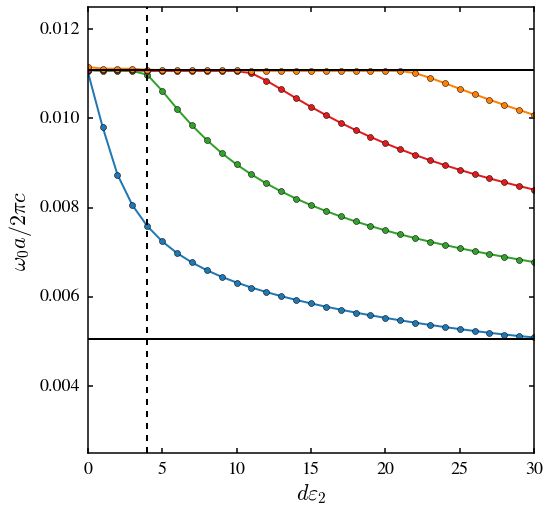

In [304]:
plt.plot(bands["tm band %d" % defect_band], 'o-');
# plt.plot(bands["tm band %d" % (defect_band-1)], 'ko-');
plt.plot(bands["tm band %d" % (defect_band+1)], 'o-');
plt.plot(bands["tm band %d" % (defect_band+2)], 'o-');
plt.plot(bands["tm band %d" % (defect_band+3)], 'o-');
# plt.plot(bands["tm band %d" % (defect_band+4)], 'ko-');
plt.axhline(bands["tm band %d" % (defect_band-1)][0], c='k');
plt.axhline(bands["tm band %d" % (defect_band+1)][0], c='k');
plt.axvline(4, ls='--',c='k');
plt.ylim(0.1/N,0.5/N);
plt.ylabel(r"${\omega_0 a}/{2 \pi c}$")
plt.xlabel(r"$d\varepsilon_2$");
plt.savefig("3c-1.pdf", bbox_inches='tight', facecolor='none')

---

In [303]:
%%sh
cd 3c/defect2
mpb deps2=5 N=40 defect1d.ctl > defect2.out
cd ../..

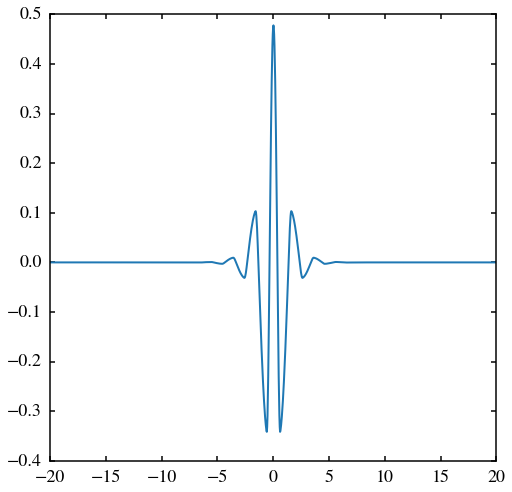

In [306]:
with h5py.File("./3c/defect2/defect1d-e.k01.b%02d.z.tm.h5" % (defect_band)) as field_data:
    efield = field_data["z.r"].value
    X_max = field_data["lattice vectors"].value[0,0] / 2
    nX = efield.shape[0]
    X = np.mgrid[-X_max:X_max:1j*nX]
    plt.plot(X,efield)

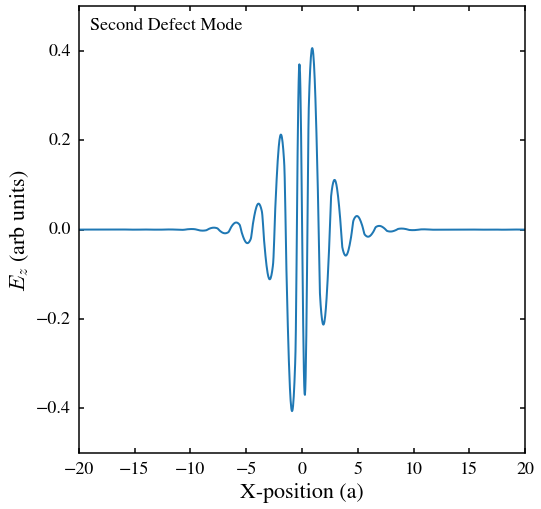

In [309]:
with h5py.File("./3c/defect2/defect1d-e.k01.b%02d.z.tm.h5" % (defect_band+1)) as field_data:
    efield = field_data["z.r"].value
    X_max = field_data["lattice vectors"].value[0,0] / 2
    nX = efield.shape[0]
    X = np.mgrid[-X_max:X_max:1j*nX]
    plt.plot(X,efield)

plt.ylabel("$E_z$ (arb units)");
plt.xlabel("X-position (a)");
plt.text(-19, 0.45, "Second Defect Mode", fontsize=18);
plt.savefig("3c-2.pdf", bbox_inches='tight', facecolor='none')

---

### Problem 3d

In [361]:
target_func = lambda x,A,k: A * np.cos(np.pi * x) * np.exp(-k*np.abs(x))

In [392]:
%%sh
cd 3d
rm -r deps*
for de in `seq 0 0.5 30`;
    do mkdir deps$de;
    cp ./defect1d.ctl deps$de/
    cd deps$de;
    mpb deps2=$de N=20 defect1d.ctl | grep "tmfreqs" > tm.eps2.dat;
    cd ..;
done
cd ..

In [397]:
N = 20
deMAX = 30
deSTEP = 0.5

deps2 = np.linspace(0.0, deMAX, int(deMAX/deSTEP) + 1)
N_defect = N+1
omega_defect = []

decay_constant = []

for de in deps2:
    b = pd.read_csv('./3d/deps%G/tm.eps2.dat' % de, index_col=[0,1], 
                    skipinitialspace=True).loc["tmfreqs:"]["tm band %d" % N_defect].values
    omega_defect.append(b[0])
    
    with h5py.File("./3d/deps%G/defect1d-e.k01.b%02d.z.tm.h5" % (de, N_defect)) as field_data:
        
        efield = field_data["z.r"].value
        X_max = field_data["lattice vectors"].value[0,0] / 2
        nX = efield.shape[0]
        X = np.mgrid[-X_max:X_max:1j*nX]
        
        p, pcov = curve_fit(target_func, X, efield, p0 = [1, 1])
        k = p[1]

        decay_constant.append(k)

omega_defect = np.array(omega_defect) / N
decay_constant = np.array(decay_constant)

In [398]:
omega_defect


array([ 0.02210815,  0.0210634 ,  0.0196168 ,  0.0184208 ,  0.0174757 ,
        0.01672155,  0.01610825,  0.0156001 ,  0.01517175,  0.0148052 ,
        0.01448735,  0.01420845,  0.0139612 ,  0.0137399 ,  0.01354015,
        0.0133586 ,  0.0131923 ,  0.01303915,  0.0128973 ,  0.01276515,
        0.0126415 ,  0.01252535,  0.01241575,  0.012312  ,  0.01221345,
        0.01211955,  0.0120298 ,  0.01194385,  0.0118613 ,  0.0117819 ,
        0.01170535,  0.0116314 ,  0.01155985,  0.0114906 ,  0.01142335,
        0.0113581 ,  0.0112946 ,  0.01123285,  0.0111727 ,  0.01111405,
        0.0110569 ,  0.0110011 ,  0.01094665,  0.01089345,  0.0108415 ,
        0.0107908 ,  0.01074125,  0.01069285,  0.01064565,  0.01059955,
        0.0105546 ,  0.01051085,  0.01046825,  0.01042685,  0.0103867 ,
        0.01034785,  0.01031035,  0.0102743 ,  0.0102398 ,  0.010207  ,
        0.01017595])

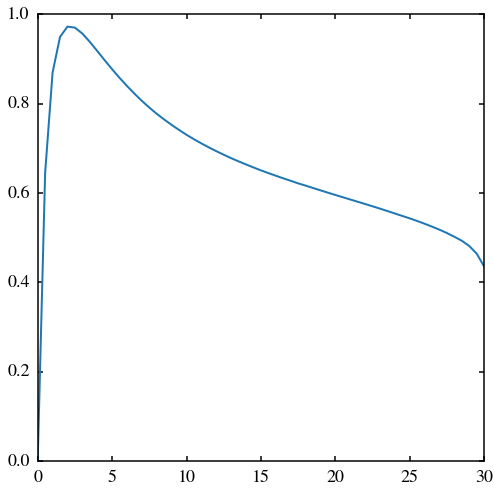

In [399]:
plt.plot(deps2, decay_constant)

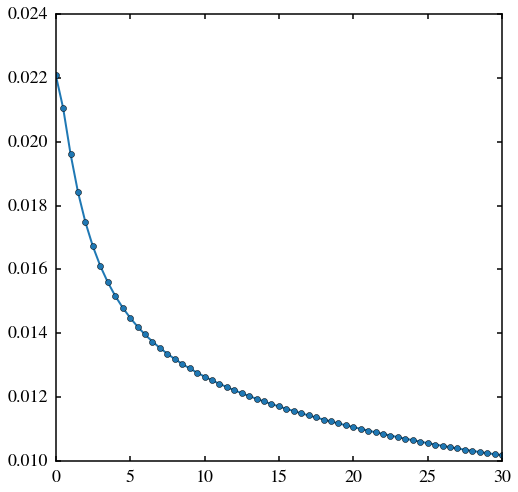

In [400]:
plt.plot(deps2,omega_defect,'o-')

In [401]:
target_func2 = lambda x,A,k: A*np.exp(-k * np.abs(x))

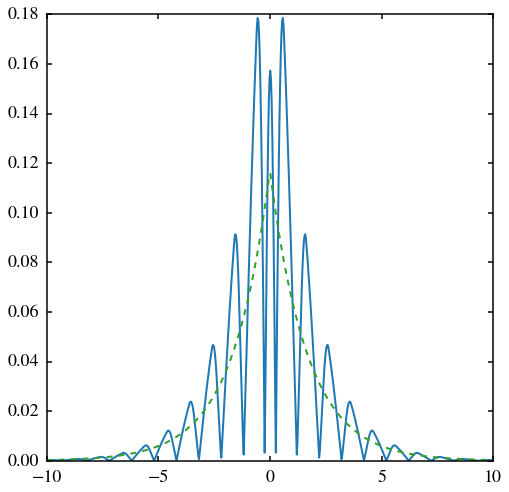

In [404]:
de = 20

with h5py.File("./3d/deps%d/defect1d-e.k01.b%02d.z.tm.h5" % (de, N_defect)) as field_data:
        
        efield = field_data["z.r"].value
        X_max = field_data["lattice vectors"].value[0,0] / 2
        nX = efield.shape[0]
        X = np.mgrid[-X_max:X_max:1j*nX]
        
        
        
        p, pcov = curve_fit(target_func, X, efield, p0 = [1, 1])
        k = p[1]
        
        plt.plot(X, np.abs(efield));
#         plt.plot(X, target_func(X,*p), '--');
        plt.plot(X, np.abs(target_func2(X,*p)), '--')


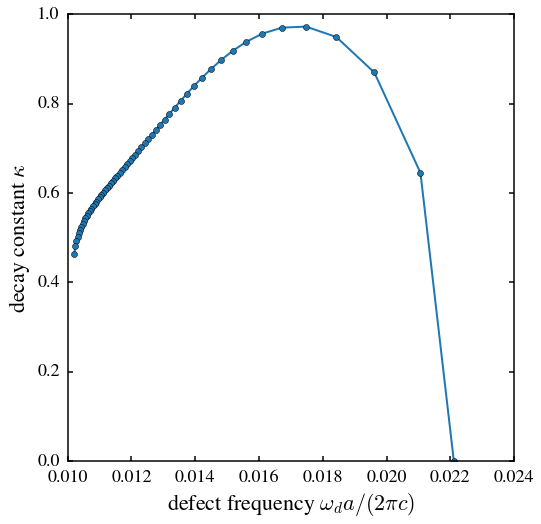

In [408]:
plt.plot(omega_defect[:-1], decay_constant[:-1], 'o-');
plt.ylabel("decay constant $\kappa$");
plt.xlabel("defect frequency $\omega_d a / (2 \pi c)$");
plt.savefig("3d-1.pdf", bbox_inches='tight', facecolor='none')